In [1]:
import logging
import os
import sys
from itertools import product
from pathlib import Path
from typing import Dict, List, Optional

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from seaborn._statistics import LetterValues
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler

NOTEBOOK_PATH: Path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
PROJECT_DIR: Path = NOTEBOOK_PATH.parent.parent
sys.path.append(str(PROJECT_DIR))
import src.utils.custom_log as custom_log
import src.utils.json_util as json_util
from src._StandardNames import StandardNames
from src.utils.PathChecker import PathChecker
from src.utils.set_rcparams import set_rcparams
from src.utils.Csv import Csv
from src.data.fe_processing.InjuryCalculator import InjuryCalculator
from src.data.fe_processing.IsoMme import IsoMme

os.chdir(PROJECT_DIR)
set_rcparams()

LOG: logging.Logger = logging.getLogger(__name__)
custom_log.init_logger(log_lvl=logging.INFO)
LOG.info("Log start, project directory is %s (exist: %s)", PROJECT_DIR, PROJECT_DIR.is_dir())

CHECK: PathChecker = PathChecker()
STR: StandardNames = StandardNames()

FULL_WIDTH: float = 448.13095 / 72 - 0.2

FIG_DIR: Path = CHECK.check_directory(PROJECT_DIR / "reports" / "figures", exit=False)
FIG_DIR /= NOTEBOOK_PATH.stem
FIG_DIR.mkdir(parents=True, exist_ok=True)
LOG.info("Figure directory is %s (exist: %s)", FIG_DIR, FIG_DIR.is_dir())
print(FULL_WIDTH)

COLORS: sns.palettes._ColorPalette = sns.color_palette()
COLORS

2025-01-05 10:03:40,852     INFO  MainProcess  MainThread Log start, project directory is /root/py_projects/aihiii (exist: True)
2025-01-05 10:03:40,854     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/reports/figures' exists
2025-01-05 10:03:40,855     INFO  MainProcess  MainThread Figure directory is /root/py_projects/aihiii/reports/figures/eval_test_set (exist: True)


6.024040972222222


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [2]:
EXP_DIR: Path = Path("experiments")
D_DIRS: Dict[int, Path] = {
    5: CHECK.check_directory(EXP_DIR / "2024-12-16-08-32-37_test_set_predictions_5HIII"),
    95: CHECK.check_directory(EXP_DIR / "2024-12-16-12-49-35_test_set_predictions_95HIII"),
}
DOE_PATH: Path = CHECK.check_file(Path("data") / "doe" / "doe_sobol_test_20240829_135200" / "doe.parquet")
DOE_REF_PATH:Path = CHECK.check_file(Path("data")/"doe"/"doe_sobol_20240705_194200"/"doe_combined.parquet")

2025-01-05 10:03:42,819     INFO  MainProcess  MainThread Directory 'experiments/2024-12-16-08-32-37_test_set_predictions_5HIII' exists
2025-01-05 10:03:42,821     INFO  MainProcess  MainThread Directory 'experiments/2024-12-16-12-49-35_test_set_predictions_95HIII' exists
2025-01-05 10:03:42,822     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_test_20240829_135200/doe.parquet' exists
2025-01-05 10:03:42,823     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/doe_combined.parquet' exists


In [3]:
PRED_NAME:str = "y_pred_test.parquet"
TRUE_NAME:str = "y_true_test.parquet"

In [4]:
RENAMER: Dict[str, str] = {
    "Chest_Deflection": "CDC",
    "Chest_VC": "CVC",
    "Chest_a3ms": "CAC$_3$",
    "Femur_Fz_Max_Compression": "FCC",
    "Head_HIC15": "HIC$_{15}$",
    "Head_a3ms": "HAC$_3$",
    "Neck_Fx_Shear_Max": "NSC",
    "Neck_Fz_Max_Tension": "NTC",
    "Neck_My_Extension": "NEC",
}
INJ_CRIT: List[str] = [
    "Head_HIC15",
    "Head_a3ms",
    "Neck_My_Extension",
    "Neck_Fz_Max_Tension",
    "Neck_Fx_Shear_Max",
    "Chest_Deflection",
    "Chest_VC",
    "Chest_a3ms",
    "Femur_Fz_Max_Compression",
]

In [5]:
pd.read_parquet(D_DIRS[5] / TRUE_NAME)

,Chest_Deflection,Chest_VC,Chest_a3ms,Femur_Fz_Max_Compression,Head_HIC15,Head_a3ms,Neck_Fx_Shear_Max,Neck_Fz_Max_Tension,Neck_My_Extension
ID,,,,,,,,,
0.0,29.508516,0.224640,37.756042,0.773261,194.602844,46.798645,1.556872,1.606085,15.410590
1.0,33.626637,0.335856,48.437160,0.728450,374.149567,62.225826,0.625050,1.911784,21.835148
2.0,34.111046,0.381764,49.983444,0.742882,287.109924,55.138279,1.276839,2.465945,18.208145
3.0,29.274422,0.279046,48.880291,0.709567,427.515350,64.784233,0.472253,1.394163,19.357906
4.0,33.418007,0.341561,57.022446,0.711798,615.232727,77.759926,0.655723,2.065582,20.958382
...,...,...,...,...,...,...,...,...,...
251.0,34.125790,0.380714,51.173267,0.744000,400.264923,63.077610,1.132840,1.969850,24.263952
252.0,33.567154,0.266521,50.587807,0.811657,339.023590,60.600780,1.505834,2.033079,22.236095
253.0,29.029318,0.281388,56.207333,0.758695,574.454956,74.267143,0.528721,1.252558,25.353086


2025-01-05 10:04:56,739     INFO  MainProcess  MainThread Index of Y_TRUE and Index of Y_PRED are identical
/tmp/ipykernel_698400/1812636819.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[j, i].scatter(doe.loc[loss.index, val], loss[crit], s=1, c=sc_col, label="Loss")
/tmp/ipykernel_698400/1812636819.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[j, i].scatter(doe.loc[loss.index, val], loss[crit], s=1, c=sc

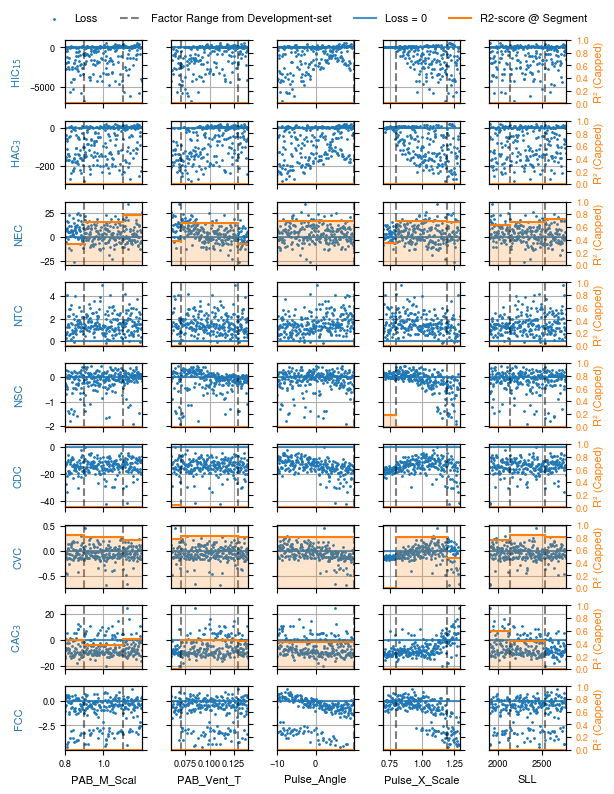

In [6]:
def plot(perc: int = 95):
    # calculate loss
    y_true = pd.read_parquet(D_DIRS[perc] / TRUE_NAME)
    y_pred = pd.read_parquet(D_DIRS[perc] / PRED_NAME)
    if all(y_true.index == y_pred.index):
        LOG.info("Index of Y_TRUE and Index of Y_PRED are identical")
    else:
        LOG.error("Index of Y_TRUE and Index of Y_PRED are NOT identical")
    loss = y_true - y_pred

    # get DOEs
    doe = pd.read_parquet(DOE_PATH, filters=[(STR.perc, "==", 5), (STR.id, "in", loss.index)]).drop(columns=STR.perc)
    doe_ref = pd.read_parquet(DOE_REF_PATH, filters=[(STR.perc, "==", 5)]).drop(columns=STR.perc)
    doe_ref_min, doe_ref_max = doe_ref.min(), doe_ref.max()
    del doe_ref

    scores = {}
    for val in doe.columns:
        idx = y_true[doe[val].lt(doe_ref_min[val])].index
        if len(idx):
            scores[val] = pd.Series(
                r2_score(y_true=y_true.loc[idx], y_pred=y_pred.loc[idx], multioutput="raw_values"), index=y_true.columns
            )
            scores[val][scores[val] < 0] = 0
    scores_min = pd.DataFrame(scores)
    scores = {}
    for val in doe.columns:
        idx = y_true[doe[val].gt(doe_ref_max[val])].index
        if len(idx):
            scores[val] = pd.Series(
                r2_score(y_true=y_true.loc[idx], y_pred=y_pred.loc[idx], multioutput="raw_values"), index=y_true.columns
            )
            scores[val][scores[val] < 0] = 0
    scores_max = pd.DataFrame(scores)
    scores = {}
    for val in doe.columns:
        idx = y_true[doe[val].between(doe_ref_min[val], doe_ref_max[val])].index
        if len(idx):
            scores[val] = pd.Series(
                r2_score(y_true=y_true.loc[idx], y_pred=y_pred.loc[idx], multioutput="raw_values"), index=y_true.columns
            )
            scores[val][scores[val] < 0] = 0
    scores_mid = pd.DataFrame(scores)

    fig, ax = plt.subplots(
        nrows=loss.shape[1] + 1,
        ncols=doe.shape[1],
        sharey="row",
        sharex="col",
        layout="constrained",
        height_ratios=[0.1, *[1] * loss.shape[1]],
    )
    gs = ax[0, 0].get_gridspec()
    for ax_ in ax[0, :]:
        ax_.remove()
    axbig = fig.add_subplot(gs[0, :])
    axbig.axis("off")

    sc_col, r2_col = COLORS[0], COLORS[1]
    ax2 = []
    for j, crit in enumerate(INJ_CRIT, 1):
        for i, val in enumerate(doe.columns):
            ax[j, i].scatter(doe.loc[loss.index, val], loss[crit], s=1, c=sc_col, label="Loss")
            if i == 0:
                ax[j, i].set_ylabel(RENAMER[crit], c=sc_col)
            if j == loss.shape[1]:
                ax[j, i].set_xlabel(val)
            ax[j, i].grid()
            ax[j, i].set_axisbelow(True)
            ax[j, i].axvline(doe_ref_min[val], c="black", alpha=0.5, ls="--", label="Factor Range from Development-set")
            ax[j, i].axvline(doe_ref_max[val], c="black", alpha=0.5, ls="--")
            ax[j, i].axhline(0, c=sc_col, alpha=0.8, label="Loss = 0")
            ax[j, i].set_xlim([doe.loc[loss.index, val].min(), doe.loc[loss.index, val].max()])

            ax2 = ax[j, i].twinx()
            ax2.set_ylim([0, 1])
            ax2.set_yticks(np.linspace(0, 1, 6))
            if val in scores_mid.columns:
                ax2.plot([doe_ref_min[val], doe_ref_max[val]], [scores_mid.loc[crit, val]] * 2, c=r2_col, label="R2-score @ Segment")
                ax2.add_patch(
                    Rectangle(
                        xy=(doe_ref_min[val], 0),
                        width=doe_ref_max[val] - doe_ref_min[val],
                        height=scores_mid.loc[crit, val],
                        facecolor=r2_col,
                        alpha=0.2,
                    )
                )
            if val in scores_min.columns:
                ax2.plot([doe.loc[loss.index, val].min(), doe_ref_min[val]], [scores_min.loc[crit, val]] * 2, c=r2_col)
                ax2.add_patch(
                    Rectangle(
                        xy=(doe.loc[loss.index, val].min(), 0),
                        width=doe_ref_min[val] - doe.loc[loss.index, val].min(),
                        height=scores_min.loc[crit, val],
                        facecolor=r2_col,
                        alpha=0.2,
                    )
                )
            if val in scores_max.columns:
                ax2.plot([doe_ref_max[val], doe.loc[loss.index, val].max()], [scores_max.loc[crit, val]] * 2, c=r2_col)
                ax2.add_patch(
                    Rectangle(
                        xy=(doe_ref_max[val], 0),
                        width=doe.loc[loss.index, val].max() - doe_ref_max[val],
                        height=scores_max.loc[crit, val],
                        facecolor=r2_col,
                        alpha=0.2,
                    )
                )
            if i != doe.shape[1] - 1:
                ax2.set_yticklabels([])
            else:
                ax2.set_ylabel("R² (Capped)", c=r2_col)
                ax2.set_yticklabels(ax2.get_yticklabels(), c=r2_col)

    axbig.legend(
        ax[1, 0].get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
        ax[1, 0].get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1],
        loc="center",
        ncol=4,
        #title=f"HIII{perc:02d}{'F' if perc==5 else 'M'}",
    )
    fig.align_ylabels(ax)
    fig.set_figheight(FULL_WIDTH * 1.3)
    fig.set_figwidth(FULL_WIDTH)

    fig.savefig(FIG_DIR / f"loss_r2_{perc:02d}.pdf")


plot()

In [ ]:
def get_errors():
    scores = []
    for perc in (5, 95):
        y_true = pd.read_parquet(D_DIRS[perc] / TRUE_NAME)
        y_pred = pd.read_parquet(D_DIRS[perc] / PRED_NAME)
        if all(y_true.index == y_pred.index):
            LOG.info("Index of Y_TRUE and Index of Y_PRED are identical")
        else:
            LOG.error("Index of Y_TRUE and Index of Y_PRED are NOT identical")

        sc = pd.DataFrame(
            {
                "MAE": mean_absolute_error(y_true, y_pred, multioutput="raw_values"),
                "R2": r2_score(y_true, y_pred, multioutput="raw_values"),
            },
        )
        sc["PERC"] = perc
        sc["Crit"] = y_true.columns
        scores.append(sc)

    scores = pd.concat(scores, ignore_index=True)
    display(scores)
    scores = scores.set_index(["PERC", "Crit"])

    return scores.unstack("PERC").loc[INJ_CRIT]


get_errors()

In [5]:
FE_B_PATH = CHECK.check_directory(Path("/mnt") / "q" / "Val_Chain_Sims" / "AB_Testing")
MODEL_PATHS = {
    "TEST": CHECK.check_directory(FE_B_PATH / "400_HIII"),
    "DEV": CHECK.check_directory(FE_B_PATH / "990_Carpet_Rigid"),
}

2024-12-29 10:42:55,385     INFO  MainProcess  MainThread Directory '/mnt/q/Val_Chain_Sims/AB_Testing' exists
2024-12-29 10:42:55,391     INFO  MainProcess  MainThread Directory '/mnt/q/Val_Chain_Sims/AB_Testing/400_HIII' exists
2024-12-29 10:42:55,395     INFO  MainProcess  MainThread Directory '/mnt/q/Val_Chain_Sims/AB_Testing/990_Carpet_Rigid' exists


In [21]:
def read_score(rel_col: Optional[str] = None):
    dbs = {}
    for model_name, model_path in MODEL_PATHS.items():
        LOG.info("Reading %s", model_name)
        f_paths = model_path.rglob("injury_criteria.parquet")
        model_db = []
        for f_path in f_paths:
            LOG.info("Reading %s", f_path)
            model_db.append(pd.read_parquet(f_path, columns=rel_col).loc[["D"]])
            model_db[-1]["Case"] = f_path.parent.stem
            model_db[-1]["Assembly"] = f_path.parent.parent.stem
        LOG.info("Concatenating %s", model_name)
        dbs[model_name] = pd.concat(model_db, ignore_index=True).set_index(["Assembly", "Case"])

    absolute_error = (dbs["TEST"] - dbs["DEV"]).abs()

    display(absolute_error)

    display(absolute_error.groupby("Assembly").mean())
    display(absolute_error.groupby("Case").mean().T)
    display(absolute_error.mean(axis=0))

read_score(rel_col=INJ_CRIT)

2024-12-30 11:27:42,913     INFO  MainProcess  MainThread Reading TEST
2024-12-30 11:27:43,107     INFO  MainProcess  MainThread Reading /mnt/q/Val_Chain_Sims/AB_Testing/400_HIII/Assemblies_1/Full_Frontal/injury_criteria.parquet
2024-12-30 11:27:43,248     INFO  MainProcess  MainThread Reading /mnt/q/Val_Chain_Sims/AB_Testing/400_HIII/Assemblies_1/Moderate_Overlap_Left/injury_criteria.parquet
2024-12-30 11:27:43,284     INFO  MainProcess  MainThread Reading /mnt/q/Val_Chain_Sims/AB_Testing/400_HIII/Assemblies_1/Moderate_Overlap_Right/injury_criteria.parquet
2024-12-30 11:27:43,328     INFO  MainProcess  MainThread Reading /mnt/q/Val_Chain_Sims/AB_Testing/400_HIII/Assemblies_2/Full_Frontal/injury_criteria.parquet
2024-12-30 11:27:43,366     INFO  MainProcess  MainThread Reading /mnt/q/Val_Chain_Sims/AB_Testing/400_HIII/Assemblies_2/Moderate_Overlap_Left/injury_criteria.parquet
2024-12-30 11:27:43,397     INFO  MainProcess  MainThread Reading /mnt/q/Val_Chain_Sims/AB_Testing/400_HIII/Ass

Head_HIC15  Head_a3ms  Neck_My_Extension  \
Assembly     Case                                                               
Assemblies_1 Full_Frontal             39.869015   1.340585           8.854012   
             Moderate_Overlap_Left    23.110122   2.837854           1.472502   
             Moderate_Overlap_Right   13.092268   5.743710           2.132846   
Assemblies_2 Full_Frontal             44.151880   2.646355           0.604111   
             Moderate_Overlap_Left    12.676814   1.947714           1.098933   
             Moderate_Overlap_Right   28.126626   3.180851           4.820916   
Assemblies_3 Full_Frontal              0.343040   1.672198           3.753761   
             Moderate_Overlap_Left    18.444028   0.990717           1.415362   
             Moderate_Overlap_Right   59.034612   8.789192           2.193972   
Assemblies_4 Full_Frontal             71.404676   5.523686          14.320846   
             Moderate_Overlap_Left    35.649402   7.536320           0.993913   
             Moderate_Overlap_Right   28.032911   2.633837           4.407334   

                                     Neck_Fz_Max_Tension  Neck_Fx_Shear_Max  \
Assembly     Case                                                             
Assemblies_1 Full_Frontal                       0.365399           0.070209   
             Moderate_Overlap_Left              0.230923           0.086409   
             Moderate_Overlap_Right             0.519379           0.045748   
Assemblies_2 Full_Frontal                       0.190732           0.027969   
             Moderate_Overlap_Left              0.121106           0.062070   
             Moderate_Overlap_Right             0.078891           0.134652   
Assemblies_3 Full_Frontal                       0.424016           0.187074   
             Moderate_Overlap_Left              0.118912           0.129636   
             Moderate_Overlap_Right             0.611289           0.114148   
Assemblies_4 Full_Frontal                       0.497525           0.139515   
             Moderate_Overlap_Left              0.296475           0.078681   
             Moderate_Overlap_Right             0.060161           0.265859   

                                     Chest_Deflection  Chest_VC  Chest_a3ms  \
Assembly     Case                                                             
Assemblies_1 Full_Frontal                    1.288518  0.034577   13.209381   
             Moderate_Overlap_Left           9.109263  0.052672    5.456832   
             Moderate_Overlap_Right          5.387375  0.021355   10.207983   
Assemblies_2 Full_Frontal                    1.141167  0.000160   20.490521   
             Moderate_Overlap_Left           0.480591  0.020480    0.077960   
             Moderate_Overlap_Right          7.346830  0.040837    3.204389   
Assemblies_3 Full_Frontal                    2.763784  0.022885   15.810893   
             Moderate_Overlap_Left           7.001817  0.026301    7.713077   
             Moderate_Overlap_Right          4.353827  0.002264    2.304161   
Assemblies_4 Full_Frontal                    8.521646  0.095927    4.648403   
             Moderate_Overlap_Left           9.272844  0.052056    0.925900   
             Moderate_Overlap_Right          9.897007  0.040482    0.729152   

                                     Femur_Fz_Max_Compression  
Assembly     Case                                              
Assemblies_1 Full_Frontal                            1.387021  
             Moderate_Overlap_Left                   0.426575  
             Moderate_Overlap_Right                  0.257691  
Assemblies_2 Full_Frontal                            1.039079  
             Moderate_Overlap_Left                   0.730398  
             Moderate_Overlap_Right                  0.260428  
Assemblies_3 Full_Frontal                            0.799643  
             Moderate_Overlap_Left                   0.251994  
             Moderate_Overlap_Right             

,Head_HIC15,Head_a3ms,Neck_My_Extension,Neck_Fz_Max_Tension,Neck_Fx_Shear_Max,Chest_Deflection,Chest_VC,Chest_a3ms,Femur_Fz_Max_Compression
Assembly,,,,,,,,,
Assemblies_1,25.357135,3.307383,4.153120,0.371900,0.067455,5.261718,0.036201,9.624732,0.690429
Assemblies_2,28.318440,2.591640,2.174654,0.130243,0.074897,2.989529,0.020492,7.924290,0.676635
Assemblies_3,25.940560,3.817369,2.454365,0.384739,0.143620,4.706476,0.017150,8.609377,0.452646
Assemblies_4,45.028996,5.231281,6.574031,0.284720,0.161352,9.230499,0.062822,2.101152,0.760739


Case,Full_Frontal,Moderate_Overlap_Left,Moderate_Overlap_Right
Head_HIC15,38.942153,22.470091,32.071604
Head_a3ms,2.795706,3.328151,5.086897
Neck_My_Extension,6.883183,1.245178,3.388767
Neck_Fz_Max_Tension,0.369418,0.191854,0.317430
Neck_Fx_Shear_Max,0.106192,0.089199,0.140102
Chest_Deflection,3.428779,6.466129,6.746260
Chest_VC,0.038387,0.037877,0.026235
Chest_a3ms,13.539800,3.543442,4.111421
Femur_Fz_Max_Compression,1.098733,0.511312,0.325291


Head_HIC15                  31.161283
Head_a3ms                    3.736918
Neck_My_Extension            3.839043
Neck_Fz_Max_Tension          0.292900
Neck_Fx_Shear_Max            0.111831
Chest_Deflection             5.547056
Chest_VC                     0.034166
Chest_a3ms                   7.064888
Femur_Fz_Max_Compression     0.645112
dtype: float64